> Created on Mon Jun 12 15:03:15 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.6 时空序列

## 3.6.1 从 RNN 到 LSTM

### 3.6.1.1 RNN（Recurrent Neural Networks）

当处理序列数据（sequential data），例如*时空序列分析*部分提到的 AoT 城市环境传感器时间序列数据，*动态街景视觉感知*部分提到的用于无人驾驶场景下计算机视觉算法评测数据集 KITTI，*空间动力学——空间马尔可夫链*部分提到的历年 MCD12Q1_v006 lulc 数据，及各类型连续时间的遥感影像数据、实时城市活动动态（交通流、信息流、社交媒体等各类热力图）等，其各样本数据点（data point）并不是独立的，例如当前污染气体$CO_2$的浓度依赖于前一时刻或之前更长时间段内$CO_2$的浓度（时间相关），沿城市道路后一位置点的城市属性（例如 POI、人口密度、LULC 等）依赖于前一位置点的属性（空间相关）等，那么处理数据点之间具有独立性假设的一般标准的神经网络用于序列数据则会丢失网络的整个状态，即丢失数据点之间的时空相关性。

在*空间马尔可夫链*部分解释了经典离散（时间）马尔可夫链（Discrete-time Markov chain，D(T)MC）和空间马尔科夫 （Spatial Markov），模拟了观测序列中状态之间的转换；在*马尔可夫随机场（MRF）和城市降温模型的 MRF 推理*部分解释了马尔可夫网（马尔科夫随机场）。发展于马尔可夫链的隐马尔可夫模型（Hidden Markov Model），用来描述含有隐含未知参数（不可观测到的状态）的马尔可夫过程，将观测到的序列建模为依赖于未观测到的一系列状态的概率。但是传统的马尔可夫模型的计算量与各随机变量的状态数量呈指数增长，且每个隐藏状态通常只能依赖于上一个状态，而递归神经网络（Recurrent Neural Networks，RNN）可以捕获长期（long-range）的时空依赖性，其任何时空点的隐藏状态都可以包含来自任意长度的上下文时间窗（arbitrarily long context window）；并且网络的计算量并不会指数增长<sup>[Lipton, Z. C., Berkowitz, J. & Elkan, C. A Critical Review of Recurrent Neural Networks for Sequence Learning. (2015).]</sup>。

RNN 为前馈神经网络（feedforward neural networks），从算法解析的图中可以观察到，在$t$时刻（时间步，或空间位置），隐藏节点（hidden node）$h_t$的值来源于两个分支，一个是当前时刻的数据点输入$x_t$乘以权重值$w_{ih}$加上偏置$b_{ih}$；另一个分支是前一时刻隐藏节点的值乘以权重$w_{hh}$加上偏置$b_{hh}$。通过激活函数（通常用 Relu 和 Tanh 实现非线性）的两个分支的和即为当前时刻隐藏节点的值，各个输入的数据点和隐藏层的值计算同上。对于开始时刻输入的隐藏节点的值通常配置为张量0。这样就构建了当前时刻的状态与其前一时刻状态的关联。各时刻的输出值为对应隐藏节点值乘以权重$w_{ho}$加上偏置$b_{ho}$获得。对于输入序列的每一个元素（数据点），各层计算公式可以写作$h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})$<sup>[PyTorch-RNN, <https://pytorch.org/docs/stable/generated/torch.nn.RNN.html>.]</sup>，式中，$h_t$是当前时刻$t$的隐藏状态（hidden state），$x_t$是当前时刻$t$的输入，$h_{t-1}$是前一时刻$t-1$隐藏状态或者为时刻 0 时的初始状态。

<img src="../imgs/3_6/3_6_02.jpg" height='auto' width=800 title="caDesign"> 

In [1]:
%load_ext autoreload 
%autoreload 2 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
    
import usda.data_visual as usda_vis    
import usda.utils as usda_utils
import usda.models as usda_models

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

* 多层 RNN

`PyTorch`库包含有 RNN 网络，下述代码配置了其输入参数`num_layers=2`，该参数为递归（循环）的层数，意味着两个 RNN 堆叠在一起构成叠合的 RNN（stackedRNN），第2个RNN以第1个RNN的输出为输入，第2个RNN的输出为最终的输出，如下网络结构示例图<sup>[Deep Recurrent Nets character generation demo, <https://cs.stanford.edu/people/karpathy/recurrentjs/>]</sup>。

<img src="../imgs/3_6/3_6_04.jpg" height='auto' width=600 title="caDesign"> 

以一个文本序列`neural`输入为例，首先将文本字符串转换为整数标签，并通过除以最大字符标签数将其标准化，且调整形状为`(1,6,1)`，为1个样本下有6个数据点，每次输入一个数据点，即特征数参数`input_size`为1。并配置隐藏状态的特征数`hidden_size`为5，递归层数`num_layers`为2，实例初始化`nn.RNN`后，输入`neural`整数化的一个样本。从输出结果可以观察到，`output`即为第2个 RNN 的输出结果。

首先构建样本数据。

In [20]:
raw_text=r'neural'.lower()
chars=sorted(list(set(raw_text)))
char_to_int=dict((c, i) for i, c in enumerate(chars))

X=torch.tensor([char_to_int[char] for char in raw_text],dtype=torch.float32).reshape(1,len(raw_text),1)/len(chars)
print(X.shape,'\n',X)

torch.Size([1, 6, 1]) 
 tensor([[[0.5000],
         [0.1667],
         [0.8333],
         [0.6667],
         [0.0000],
         [0.3333]]])


激活函数默认配置为`Tanh`，对应参数`nonlinearity`，值域为-1到1。

In [21]:
input_size=1
hidden_size=3
num_layers=2

rnn=nn.RNN(input_size, hidden_size, num_layers)
print(rnn)
h0=torch.randn(num_layers, X.shape[1], hidden_size)
output, hn=rnn(X, h0)
print(output.shape,hn.shape)
print(output,'\n','-'*50,'\n',hn)

RNN(1, 3, num_layers=2)
torch.Size([1, 6, 3]) torch.Size([2, 6, 3])
tensor([[[-0.4898, -0.0451,  0.5158],
         [-0.2987,  0.5905,  0.2265],
         [-0.0492, -0.7288, -0.2116],
         [-0.4321, -0.2413, -0.7025],
         [-0.4563,  0.5862,  0.0823],
         [-0.0016,  0.0199,  0.2315]]], grad_fn=<StackBackward0>) 
 -------------------------------------------------- 
 tensor([[[-0.1867,  0.0805,  0.5953],
         [-0.5911,  0.9160,  0.3573],
         [-0.7828,  0.2346,  0.8274],
         [-0.5516,  0.2513,  0.8900],
         [-0.7596,  0.9361,  0.2073],
         [-0.4027,  0.8579,  0.4963]],

        [[-0.4898, -0.0451,  0.5158],
         [-0.2987,  0.5905,  0.2265],
         [-0.0492, -0.7288, -0.2116],
         [-0.4321, -0.2413, -0.7025],
         [-0.4563,  0.5862,  0.0823],
         [-0.0016,  0.0199,  0.2315]]], grad_fn=<StackBackward0>)


* 双向递归神经网络 BRNN

对于许多序列标记任务，不仅是当前时刻从过往时刻的数据点获得信息，往往也需要从将来时刻的数据点获得信息，因此Schuster, M. 等人提出了双向递归神经网络（Bidirectional Recurrent Neural Networks，BRNN），可以使用特定时间范围内过去和未来的所有可用输入信息进行训练<sup>[Schuster, M. & Paliwal, K. K. Bidirectional Recurrent Neural Networks. IEEE TRANSACTIONS ON SIGNAL PROCESSING vol. 45 (1997).]</sup>。BRNN 的基本思想是将每个训练序列向前和向后表述为两个独立的递归隐藏层，这两个隐藏层都连接到同一个输出层，如图<sup>[Graves, A. Supervised Sequence Labelling with Recurrent Neural Networks. in Studies in Computational Intelligence (2012).]26</sup>。

<img src="../imgs/3_6/3_6_06.jpg" height='auto' width=600 title="caDesign"> 

`PyTorch`提供的 RNN 方法中可以直接配置`bidirectional=True`实现 BRNN。隐藏节点初始化的张量`h_0`形状为$(D * num_layers,H_{out})$，当配置 RNN 网络为 BRNN 时，其$D=2$。下述试验配置`num_layers=1`，可以发现训练序列的每一数据点的输出值`output`为隐藏节点数的2倍；隐藏节点`hn`包含合并的前向和后向两个独立隐藏层的张量。

In [11]:
num_layers=1
rnn=nn.RNN(input_size, hidden_size, num_layers,bidirectional=True)
print(rnn)
h0=torch.randn(num_layers*2, X.shape[1], hidden_size)
output, hn=rnn(X, h0)
print(output.shape,hn.shape)
print(output,'\n','-'*50,'\n',hn)

RNN(1, 3, bidirectional=True)
torch.Size([1, 6, 6]) torch.Size([2, 6, 3])
tensor([[[-0.0948,  0.8778, -0.6792, -0.4503,  0.2629,  0.1734],
         [-0.2018,  0.7779, -0.1665, -0.9079,  0.8410,  0.4358],
         [ 0.3702,  0.5908,  0.4314,  0.3850, -0.6145,  0.1485],
         [ 0.8645,  0.0013, -0.4648, -0.7760,  0.0113,  0.8661],
         [-0.0232,  0.4756,  0.6359,  0.2150, -0.0758, -0.1035],
         [ 0.8035, -0.1572,  0.0789,  0.8305, -0.9462,  0.4790]]],
       grad_fn=<CatBackward0>) 
 -------------------------------------------------- 
 tensor([[[-0.0948,  0.8778, -0.6792],
         [-0.2018,  0.7779, -0.1665],
         [ 0.3702,  0.5908,  0.4314],
         [ 0.8645,  0.0013, -0.4648],
         [-0.0232,  0.4756,  0.6359],
         [ 0.8035, -0.1572,  0.0789]],

        [[-0.4503,  0.2629,  0.1734],
         [-0.9079,  0.8410,  0.4358],
         [ 0.3850, -0.6145,  0.1485],
         [-0.7760,  0.0113,  0.8661],
         [ 0.2150, -0.0758, -0.1035],
         [ 0.8305, -0.9462, 

### 3.6.1.2 LSTM（long short-term memory）

对于上述标准的 RNN 模型，输出值与隐藏节点的权重$w_{hh}$和数据点数$N_{data points}$有$w_{hh}^{N_{data points}}$指数增长关系。因此如果隐藏节点的权重大于1，当数据点不断增多时，可能引起梯度爆炸（Gradient explosion）；如果隐藏节点的权重小于1，则可能引起梯度消失（Gradient vanishing）。并且，如果时间跨度很大，当前时刻的状态则并不能学习到较早时刻的输入信息，因此 Hochreiter, S.和 Schmidhuber, J. 提出了长短时记忆网络（long short-term memory，LSTM）<sup>[Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735–1780. doi:10.1162/neco.1997.9.8.1735]</sup>。LSTM 类似于一个带有隐藏层的标准递归神经网络，但是隐藏层中的每个普通节点被一个记忆单元（memory cell）所取代，即 LSTM 单元（LSTM unit）。每个记忆单元包含一个具有固定权重为1的自连接递归边（self-connected recurrent edge），确保梯度可以跨越多个时间点而不会消失或爆炸，为含符号$c$的顶部边表示的长时记忆（Long-Term Memory），即单元状态（Cell State），如图<sup>[Yu, Y., Si, X., Hu, C. & Zhang, J. A review of recurrent neural networks: Lstm cells and network architectures. Neural Computation vol. 31 1235–1270 Preprint at https://doi.org/10.1162/neco_a_01199 (2019).][Long short-term memory (Wikipedia), <https://en.wikipedia.org/wiki/Long_short-term_memory>]</sup>；短时记忆（Short-Term Memory）为含符号$h$，有权重的底部边，即隐藏状态（Hidden State）。

<img src="../imgs/3_6/3_6_07.jpg" height='auto' width=900 title="caDesign"> 

LSTM 通过在记忆单元中引入门（gate）机制控制特征的流转和过滤，解决“长期依赖（long-term dependencies）问题”。$t$时刻的输入为前一$t-1$时刻的输出，包括长时记忆$c_{t-1}$和短时记忆$h_{t-1}$。在记忆单元中包含有三个控制门，为遗忘门（Forget Gate）、输入门（Input Gate）和输出门（Output Gate）。在过滤特征信息时使用 Sigmoid 激活函数（$\sigma $），结合乘法实现；特征的非线性激活函数使用 Tanh。关于激活函数的解释可以查看*从解析解到数值解，从机器学习到深度学习*部分，下述打印了两个激活函数的曲线，方便观察数值区间变化，理解特征的删选机制。。

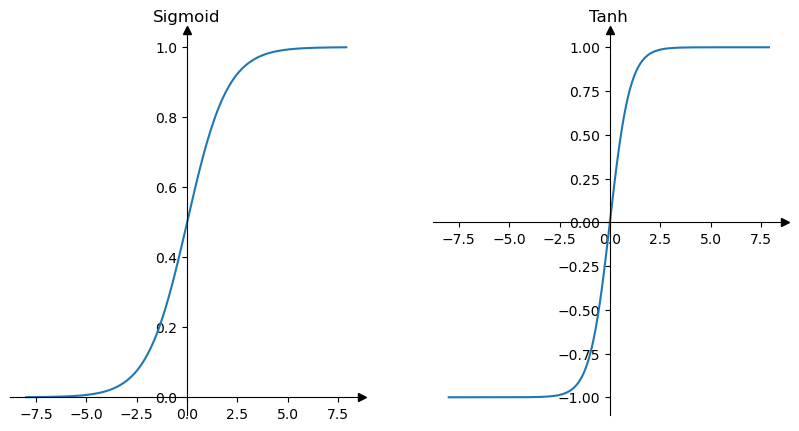

In [19]:
fig, axes=plt.subplots(1, 2,figsize=(10,5))

x=torch.arange(-8.0,8.0,0.1,requires_grad=True)
y_relu=x.sigmoid()
axes[0].plot(x.detach().numpy(), y_relu.detach().numpy(),label="ReLU")

y_tanh=x.tanh()
axes[1].plot(x.detach().numpy(), y_tanh.detach().numpy(),label="tanh")


axes[0].set_title('Sigmoid')
axes[1].set_title('Tanh')
usda_vis.plot_style_axis_A(axes[0])
usda_vis.plot_style_axis_A(axes[1])
plt.show()

**遗忘门：**

遗忘门的计算公式为$f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) $，式中$x_t$为时刻$t$时的输入；$h_{t-1}$为前一时刻的隐藏状态或时刻0时的初始状态；$W_{if}$、$W_{hf}$分别为输入值和隐藏状态的权重；$b_{if}$和$b_{hf}$为对应的偏置。遗忘门决定了哪些特征信息被保留，而哪些应该被忽略。输入特征和前一时刻的隐藏状态通过 Sigmoid 函数传递，映射到[0,1]区间。如果该值趋近于1，与前一时刻的单元状态$c_{t-1}$乘积会保持前一单元状态基本不变，意味着信息流通；否则趋近于0，意味着前一单元状态的特征信息被忽略。

**输入门：**

输入门计算为两部分的乘积，一部分同遗忘门，用于删选特征信息；另一部分为隐藏节点，对应公式分别为$i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi})$ 和$g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg})$。此时可以更新当前时刻$t$的单元状态为$c_t = f_t \odot c_{t-1} + i_t \odot g_t$，式中$\odot$为哈达玛积（Hadamard product），为两个矩阵对应元素相乘的结果。因此输入门通过更新单元状态将新的相关信息添加到了现有信息中。

**输出门**

输入门计算也为两部分的乘积，一部分为用于删选特征信息的 Sigmoid 函数，公式为$o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})$；另一部分为更新的当前时刻的单元状态$c_t$。计算输出值公式为$h_t = o_t \odot \tanh(c_t)$。输出门更新了隐藏状态$h_t$，同单元状态$c_t$作为下一时刻的输入。

继续前文试验，将 RNN 替换为 LSTM，并增加单元状态初始张量$c0$，计算结果如下。

In [25]:
input_size=1
hidden_size=3
num_layers=1

rnn=nn.LSTM(input_size, hidden_size, num_layers)
print(rnn)
h0=torch.randn(num_layers, X.shape[1], hidden_size)
c0=torch.randn(num_layers, X.shape[1], hidden_size)
output, (hn,cn)=rnn(X, (h0,c0))
print(output.shape,hn.shape,cn.shape)
print(output,'\n','-'*50,'\n',hn,'\n',cn)

LSTM(1, 3)
torch.Size([1, 6, 3]) torch.Size([1, 6, 3]) torch.Size([1, 6, 3])
tensor([[[-0.2156,  0.2163, -0.2481],
         [-0.0974,  0.4490, -0.4016],
         [-0.4627, -0.1346, -0.2763],
         [-0.0875, -0.3300, -0.0779],
         [-0.2781,  0.0431, -0.1354],
         [-0.0718, -0.0208,  0.3109]]], grad_fn=<MkldnnRnnLayerBackward0>) 
 -------------------------------------------------- 
 tensor([[[-0.2156,  0.2163, -0.2481],
         [-0.0974,  0.4490, -0.4016],
         [-0.4627, -0.1346, -0.2763],
         [-0.0875, -0.3300, -0.0779],
         [-0.2781,  0.0431, -0.1354],
         [-0.0718, -0.0208,  0.3109]]], grad_fn=<StackBackward0>) 
 tensor([[[-0.3266,  0.4154, -0.4966],
         [-0.2703,  0.8698, -0.5718],
         [-0.6668, -0.3594, -0.5487],
         [-0.6161, -1.3928, -0.1051],
         [-0.5705,  0.0955, -0.3340],
         [-0.1111, -0.0466,  0.5318]]], grad_fn=<StackBackward0>)


### 3.6.1.3 LSTM 的文本生成试验

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
torch.cuda.is_available()

False

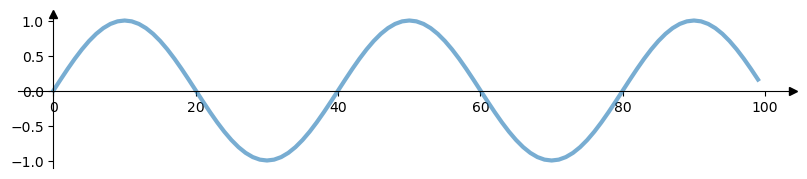

In [3]:
num=1000
x=torch.linspace(0,num-1,num)
period=40
y=torch.sin(x*2*np.pi/period)

fig, ax=plt.subplots(1, 1,figsize=(10,2))
ax.plot(x[:100],y[:100], lw=3, alpha=0.6)

usda_vis.plot_style_axis_A(ax)
plt.show()

In [4]:
test_size=100
train_set=y[:-test_size]
test_set=y[-test_size:]

window_size=period
train_data=usda_utils.sequence2series_of_overlapping_with_labels(train_set, window_size)
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
          7.0711e-01,  5.8779e-01,  4.5399e-01,  3.0902e-01,  1.5643e-01,
         -8.7423e-08, -1.5643e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5106e-01, -8.9101e-01, -8.0902e-01,
         -7.0711e-01, -5.8779e-01, -4.5399e-01, -3.0902e-01, -1.5643e-01]),
 tensor([1.7485e-07]))

In [10]:
torch.manual_seed(42)
lr=0.01

RNN_LSTM_sequence(
  (rnn_lstm): RNN(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 0 Loss:8.481218173983507e-06; Performance on test range: 0.003869572188705206


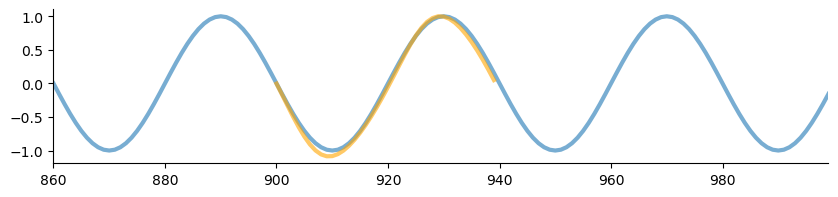

Epoch 1 Loss:1.535474984848406e-05; Performance on test range: 0.00407208688557148


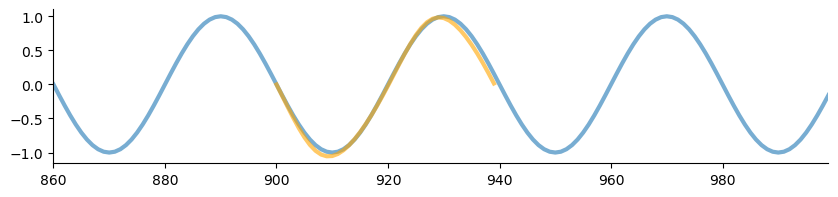

Epoch 2 Loss:1.4694256606162526e-05; Performance on test range: 0.0033605736680328846


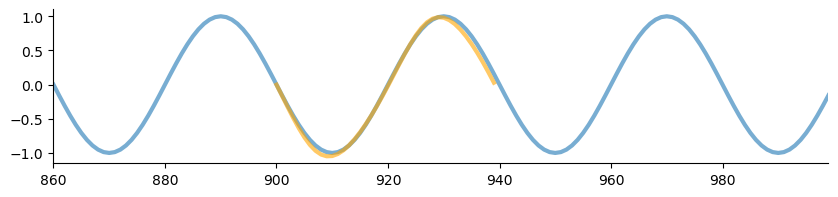

In [11]:
model=usda_models.RNN_LSTM_sequence(selection='RNN')
print(model)

criterion=nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
usda_models.RNN_LSTM_train_sequence(model,train_data,train_set,x,y,optimizer,criterion,window_size,test_size,epochs=3,future=40,plot=True)

RNN_LSTM_sequence(
  (rnn_lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 0 Loss:0.07350001484155655; Performance on test range: 0.574382483959198


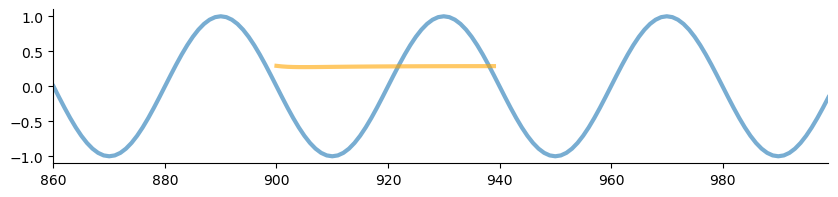

Epoch 1 Loss:0.030122658237814903; Performance on test range: 0.46689707040786743


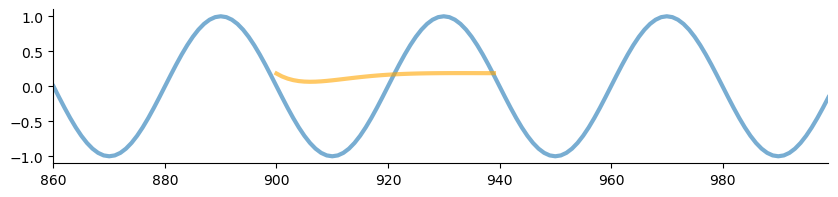

Epoch 2 Loss:0.002125221537426114; Performance on test range: 0.10097652673721313


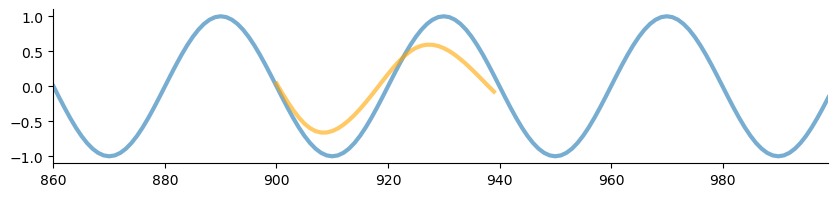

Epoch 3 Loss:0.00019723063451237977; Performance on test range: 0.0034082874190062284


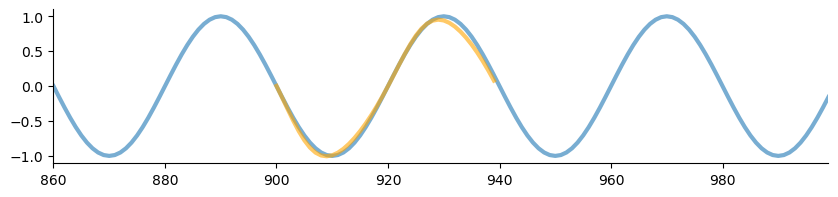

Epoch 4 Loss:0.00014400237705558538; Performance on test range: 0.002277107909321785


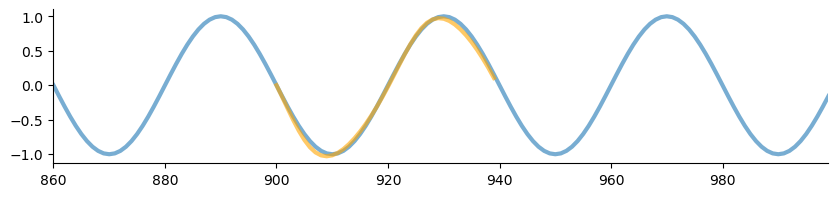

In [12]:
model=usda_models.RNN_LSTM_sequence(selection='LSTM')
print(model)

criterion=nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
usda_models.RNN_LSTM_train_sequence(model,train_data,train_set,x,y,optimizer,criterion,window_size,test_size,epochs=5,future=40,plot=True)

In [14]:
mnist_fn=r'I:\data\mnist'
traindt=datasets.MNIST(root = mnist_fn,transform=transforms.ToTensor(),train=True,download=True)
testdt=datasets.MNIST(root = mnist_fn,transform=transforms.ToTensor(),train=False,download=True)

In [15]:
print(traindt,'\n',testdt)
batch_size=100
train_loader=DataLoader(traindt, batch_size=batch_size, shuffle=False)
test_loader=DataLoader(testdt, batch_size=batch_size, shuffle=False)

Dataset MNIST
    Number of datapoints: 60000
    Root location: I:\data\mnist
    Split: Train
    StandardTransform
Transform: ToTensor() 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: I:\data\mnist
    Split: Test
    StandardTransform
Transform: ToTensor()


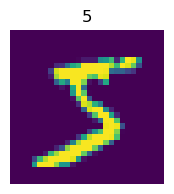

In [16]:
fig, ax=plt.subplots(1, 1,figsize=(2,2))
ax.imshow(traindt[0][0].numpy().reshape(28,28))
plt.axis("off")
plt.title(str(traindt[0][1]))
plt.show()

In [17]:
n_iters=8000
num_epochs=int(n_iters/(len(traindt)/batch_size))
print(num_epochs)

13


In [20]:
# Create RNN
input_dim=28    # input dimension
hidden_dim=100  # hidden layer dimension
layer_dim=1 # number of hidden layers
output_dim=10   # output dimension

model=usda_models.RNN_model_img(input_dim, hidden_dim,layer_dim, output_dim,)
print(model)

# Cross Entropy Loss 
error=nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate=0.05
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

RNN_model_img(
  (rnn): RNN(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


In [25]:
iteration_list,loss_list,accuracy_list=usda_models.RNN_train_img(model,train_loader,test_loader,input_dim,optimizer,error,epochs=num_epochs,step_eval=50) 

Iteration: 500  Loss: 0.9909659028053284  Accuracy: 76.11000061035156 %
Iteration: 1000  Loss: 0.6082250475883484  Accuracy: 84.36000061035156 %
Iteration: 1500  Loss: 0.7935434579849243  Accuracy: 87.54000091552734 %
Iteration: 2000  Loss: 0.24458648264408112  Accuracy: 92.19000244140625 %
Iteration: 2500  Loss: 0.0790989100933075  Accuracy: 93.0999984741211 %
Iteration: 3000  Loss: 0.21234281361103058  Accuracy: 92.87999725341797 %
Iteration: 3500  Loss: 0.24958306550979614  Accuracy: 94.06999969482422 %
Iteration: 4000  Loss: 0.18281689286231995  Accuracy: 94.80999755859375 %
Iteration: 4500  Loss: 0.27840670943260193  Accuracy: 89.4000015258789 %
Iteration: 5000  Loss: 0.18332625925540924  Accuracy: 94.76000213623047 %
Iteration: 5500  Loss: 0.049436092376708984  Accuracy: 96.48999786376953 %
Iteration: 6000  Loss: 0.21413767337799072  Accuracy: 96.08999633789062 %
Iteration: 6500  Loss: 0.12760573625564575  Accuracy: 96.44999694824219 %
Iteration: 7000  Loss: 0.09869009256362915  

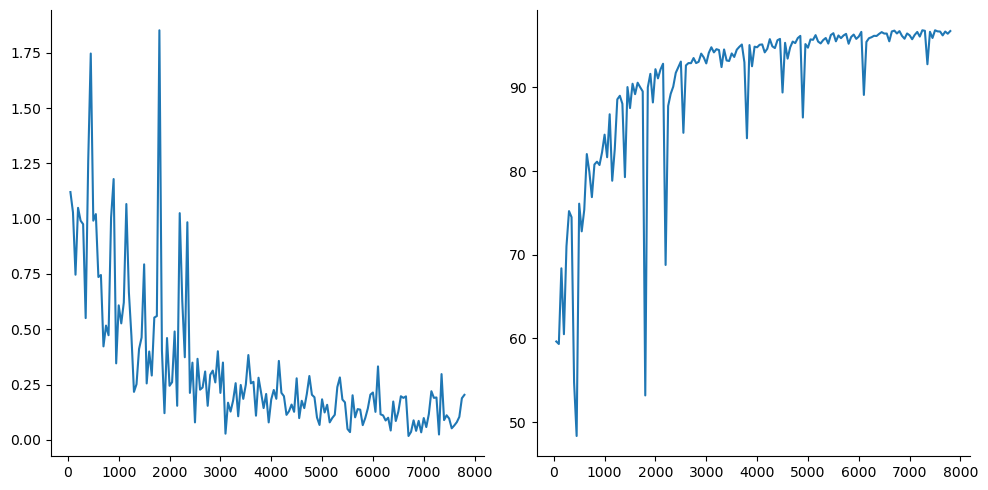

In [29]:
fig, axs=plt.subplots(1, 2,figsize=(10,5))
axs[0].plot(iteration_list,loss_list)
axs[1].plot(iteration_list,accuracy_list)
  
axs[0].spines[['right', 'top']].set_visible(False)
axs[1].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
plt.show()            

In [57]:
a=3289+4899+2005+17854+24073+11935+16230+18440+16971+12084+9701+10542+7349+14246+17086+8409+9209+19835+13435+11289+10496+10553+17744+11019+15809+20323+12483+19774+32625+14891+20740+19236+23264+27238+10804+9462+6611
print(a)
b=31237+27424+26669+25145+9457+8821+25415+24040+26026+14543+3893+10643+12737+8985+8757+6262+5614+7286+4622+3918
print(b)
print(a+b)

531953
291494
823447


In [62]:
c=r'3289+4899+2005+17854+24073+11935+16230+18440+16971+12084+9701+10542+7349+14246+17086+8409+9209+19835+13435+11289+10496+10553+17744+11019+15809+20323+12483+19774+32625+14891+20740+19236+23264+27238+10804+9462+6611'
cc=len(c.split('+')) 

d=r'31237+27424+26669+25145+9457+8821+25415+24040+26026+14543+3893+10643+12737+8985+8757+6262+5614+7286+4622+3918'
dd=len(d.split('+'))
print(cc,dd,cc+dd)

37 20 57
